# OCMR Tutorial

This is a tutorial to read the k-space from OCMR datasets. The tutorial includes a brief instrucion to <b>install ISMRMRD libraries (1) </b>, <b>filter and download OCMR data (2)</b>, <b>an example of reading k-space from OCMR data (3)</b> and <b>the code to reconstruct fully sampled OCMR datasets (4)</b>. Please intall 'ismrmrd-python' and 'ismrmrd-python-tools' before running the example. The example demonstrates how to read k-space from 'us_0165_pt_1_5T.h5', which is a prosective undersampled patient dataset (6-slices LAX stack), collected on Siemens 1.5T Sola scanner. The code is tested using 'Anaconda3->Jupyter Lab 1.2.6'. 

## 1. Install ISMRMRD libraries

> ### Linux
> #### Install ismrmrd-python https://github.com/ismrmrd/ismrmrd-python

In [ ]:
%%bash
if [ $(pip list --disable-pip-version-check | grep -c -w 'ismrmrd ') == 0 ] 
then 
    git clone https://github.com/ismrmrd/ismrmrd-python.git /var/tmp/ismrmrd-python
    python -m pip install --disable-pip-version-check -r /var/tmp/ismrmrd-python/requirements.txt
    python -m pip install --disable-pip-version-check /var/tmp/ismrmrd-python
    rm -rf /var/tmp/ismrmrd-python
fi
pip list --disable-pip-version-check | grep -w 'ismrmrd '

> #### Install ismrmrd-python-tools https://github.com/ismrmrd/ismrmrd-python-tools 

In [ ]:
%%bash
if [ $(pip list --disable-pip-version-check | grep -c -w 'ismrmrd-python-tools ') == 0 ] 
then 
    git clone https://github.com/ismrmrd/ismrmrd-python-tools.git /var/tmp/ismrmrd-python-tools
    python -m pip install --disable-pip-version-check /var/tmp/ismrmrd-python-tools
    rm -rf /var/tmp/ismrmrd-python-tools
fi
pip list --disable-pip-version-check | grep -w 'ismrmrd-python-tools '

> #### Download the "read_ocmr.py script" and "ocmr_data_attributes.csv"

In [ ]:
%%bash
wget https://raw.githubusercontent.com/MRIOSU/OCMR/master/Python/read_ocmr.py
wget https://raw.githubusercontent.com/MRIOSU/OCMR/master/ocmr_data_attributes.csv

> ### Windows
> #### Install ismrmrd-python https://github.com/ismrmrd/ismrmrd-python

In [1]:
tmp = !pip list --disable-pip-version-check | findstr /c:"ismrmrd "
if not tmp:
    !git clone https://github.com/ismrmrd/ismrmrd-python.git ./tmp_ismrmrd-python
    !python -m pip install --disable-pip-version-check -r ./tmp_ismrmrd-python/requirements.txt
    !python -m pip install --disable-pip-version-check ./tmp_ismrmrd-python
    %rmdir /s /q tmp_ismrmrd-python
!pip list --disable-pip-version-check | findstr /c:"ismrmrd "

ismrmrd                            1.6.6              


> #### Install ismrmrd-python-tools https://github.com/ismrmrd/ismrmrd-python-tools 

In [2]:
tmp = !pip list --disable-pip-version-check | findstr "ismrmrd-python-tools "
if not tmp:
    !git clone https://github.com/ismrmrd/ismrmrd-python-tools.git ./tmp_ismrmrd-python-tools
    !python -m pip install --disable-pip-version-check ./tmp_ismrmrd-python-tools
    %rmdir /s /q tmp_ismrmrd-python-tools
!pip list --disable-pip-version-check | findstr "ismrmrd-python-tools "

ismrmrd-python-tools               0.3                


> #### Download the "read_ocmr.py script" and "ocmr_data_attributes.csv"

In [ ]:
!wget --no-check-certificate https://raw.githubusercontent.com/MRIOSU/OCMR/master/Python/read_ocmr.py
!wget --no-check-certificate https://raw.githubusercontent.com/MRIOSU/OCMR/master/ocmr_data_attributes.csv

## 2. Finding and Downloading OCMR Data Files

The 'ocmr_data_attributes.csv' file (also avaible in the root of the S3 ocmr bucket https://ocmr.s3.us-east-2.amazonaws.com/ocmr_data_attributes.csv) contains a catalog of h5 files and their characteristics. The example below uses the pandas library to load this list and filter by 'file name', 'scn', and 'viw', then download each file in the filtered list using the AWS python SDK (boto3).

### Install the latest version of pandas 

In [4]:
!python -m pip install --upgrade pandas
#!python -m pip list --disable-pip-version-check | grep -w 'pandas '
import pandas

Requirement already up-to-date: pandas in c:\users\che249\anaconda3\lib\site-packages (1.0.5)


### Load the ocmr_data_attributes file into a pandas DataFrame

In [5]:
# NOTE: Change this to the S3 location when finalized
ocmr_data_attributes_location = './ocmr_data_attributes.csv'

df = pandas.read_csv('./ocmr_data_attributes.csv')
# Cleanup empty rows and columns
df.dropna(how='all', axis=0, inplace=True)
df.dropna(how='all', axis=1, inplace=True)

# Show the first 10 items in the list
df.head(10)

,file name,scn,smp,ech,dur,viw,sli,fov,sub,slices
0,fs_0001_1_5T.h5,15avan,fs,asy,shr,lax,ind,noa,vol,1.0
1,fs_0002_1_5T.h5,15avan,fs,asy,shr,lax,ind,noa,vol,1.0
2,fs_0003_1_5T.h5,15avan,fs,asy,shr,lax,ind,noa,vol,1.0
3,fs_0004_1_5T.h5,15avan,fs,asy,shr,sax,ind,noa,vol,1.0
4,fs_0005_1_5T.h5,15avan,fs,asy,shr,sax,ind,noa,vol,1.0
5,fs_0006_1_5T.h5,15avan,fs,asy,shr,sax,ind,noa,vol,1.0
6,fs_0007_1_5T.h5,15avan,fs,sym,shr,lax,ind,noa,vol,1.0
7,fs_0008_1_5T.h5,15avan,fs,sym,shr,lax,ind,noa,vol,1.0
8,fs_0009_1_5T.h5,15avan,fs,sym,shr,sax,ind,noa,vol,1.0
9,fs_0010_1_5T.h5,15avan,fs,sym,shr,sax,ind,noa,vol,1.0


 ### Filter the files based on their attributes

In [6]:
# This is a sample query that filters on file names that contain "fs_", scn equals "15avan", and viw equals "lax" 
# (i.e. fully sampled, LAX view, collected on 1.5T Avanto)
selected_df = df.query ('`file name`.str.contains("fs_") and scn=="15avan" and viw=="lax"', engine='python')
selected_df

,file name,scn,smp,ech,dur,viw,sli,fov,sub,slices
0,fs_0001_1_5T.h5,15avan,fs,asy,shr,lax,ind,noa,vol,1.0
1,fs_0002_1_5T.h5,15avan,fs,asy,shr,lax,ind,noa,vol,1.0
2,fs_0003_1_5T.h5,15avan,fs,asy,shr,lax,ind,noa,vol,1.0
6,fs_0007_1_5T.h5,15avan,fs,sym,shr,lax,ind,noa,vol,1.0
7,fs_0008_1_5T.h5,15avan,fs,sym,shr,lax,ind,noa,vol,1.0


### Install the latest version of AWS Python SDK (boto3)

In [7]:
!python -m pip install --disable-pip-version-check -qq --upgrade boto3
#!python -m pip list --disable-pip-version-check | grep -w 'boto3 '
import boto3
from botocore import UNSIGNED
from botocore.client import Config

 ### Download each file from S3

In [8]:
import os

# The local path where the files will be downloaded to
download_path = './ocmr_data'

# Replace this with the name of the OCMR S3 bucket 
bucket_name = 'ocmr'

if not os.path.exists(download_path):
    os.makedirs(download_path)
    
count=1
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# Iterate through each row in the filtered DataFrame and download the file from S3. 
# Note: Test after finalizing data in S3 bucket
for index, row in selected_df.iterrows():
    print('Downloading {} to {} (File {} of {})'.format(row['file name'], download_path, count, len(selected_df)))
    s3_client.download_file(bucket_name, 'data/{}'.format(row['file name']), '{}/{}'.format(download_path,row['file name']))
    count+=1

## 3. An example of reading k-space from OCMR data

Before running the example, please make sure ismrmrd-python and ismrmrd-python tools have been installed sucessfully.
### Import the required libraries

In [9]:
# import required library
import numpy as np
import matplotlib.pyplot as plt
import math

from ismrmrdtools import show, transform

# import ReadWrapper
import read_ocmr as read

### Read k-space from h5 file and display scan parameters
 Modify 'filename' as needed. The example undersampled dataset 'us_0165_pt_1_5T.h5' can be downloaded here: https://ocmr.s3.us-east-2.amazonaws.com/data/us_0165_pt_1_5T.h5. 

Once the data is read using readwrapper (read_ismrmrd.py), it yields two outputs. The first one is k-space, whose dimension is fixed as:  [ kx, ky, kz ,coil, phase, set, slice, repetation, average ].Anothor one is'param', which includes some basic parameters of the scan, such as field of view (FOV, mm), temporal resolution (TRes, ms), flip angle (fligAngle_deg, degress). Note, the readout dimension includes a factor of two oversampling, leading to FOV(1) that is twice the value selected on the scanner.

In [10]:
# Load the data, display size of kData and scan parmaters
filename = './ocmr_data/us_0165_pt_1_5T.h5'
kData,param = read.read_ocmr(filename);

print('Dimension of kData: ', kData.shape)
print('Scan paramters:')
import pprint; pprint.pprint(param)

Imaging acquisition starts acq  32
Dimension of kData:  (352, 126, 1, 24, 30, 1, 6, 1, 1)
Scan paramters:
{'FOV': [800.0, 306.220093, 7.0],
 'TE': '[1.19]',
 'TI': '[300.0]',
 'TRes': '[49.32]',
 'echo_spacing': '[2.74]',
 'flipAngle_deg': '[80.0]',
 'kspace_dim': {'kx ky kz coil phase set slice rep avg'},
 'sequence_type': 'SSFP'}


### Display the sampling pattern
Modify 'slc_idx' as needed. The default value is the central slice. As shown in the following figure, this dataset is prospective undersampled with pseudo-random
sampling and assymetry echo on.

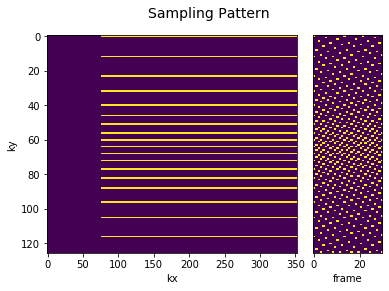

In [11]:
# Show the sampling Pattern
# kData_tmp-[kx,ky,kz,coil,phase,set,slice,rep], samp-[kx,ky,kz,phase,set,slice,rep]
dim_kData = kData.shape; CH = dim_kData[3]; SLC = dim_kData[6]; 
kData_tmp = np.mean(kData, axis = 8); # average the k-space if average > 1
samp = (abs(np.mean(kData_tmp, axis = 3)) > 0).astype(np.int) # kx ky kz phase set slice

slc_idx = math.floor(SLC/2);
fig1 = plt.figure(1); fig1.suptitle("Sampling Pattern", fontsize=14);
plt.subplot2grid((1, 8), (0, 0), colspan=6);
tmp = plt.imshow(np.transpose(np.squeeze(samp[:,:,0,0,0,slc_idx])), aspect= 'auto');
plt.xlabel('kx');plt.ylabel('ky'); tmp.set_clim(0.0,1.0) # ky by kx
plt.subplot2grid((1, 9), (0, 7),colspan=2);
tmp = plt.imshow(np.squeeze(samp[int(dim_kData[0]/2),:,0,:,0,slc_idx]),aspect= 'auto'); 
plt.xlabel('frame');plt.yticks([]); tmp.set_clim(0.0, 1.0) # ky by frame

### Display the time averaged image
Time averaged image of the central slice, where the coil images are combined using SOS(sum of square.)

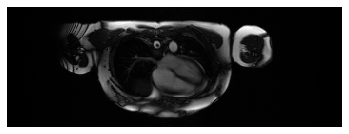

In [12]:
# Average the k-sapce along phase(time) dimension
kData_sl = kData_tmp[:,:,:,:,:,:,slc_idx,0];
samp_avg =  np.repeat(np.sum(samp[:,:,:,:,:,slc_idx,0],3), CH, axis=3) + np.finfo(float).eps
kData_sl_avg = np.divide(np.squeeze(np.sum(kData_sl,4)), np.squeeze(samp_avg));

im_avg = transform.transform_kspace_to_image(kData_sl_avg, [0,1]); # IFFT (2D image)
im = np.sqrt(np.sum(np.abs(im_avg) ** 2, 2)) # Sum of Square
fig2 = plt.figure(1); plt.imshow(np.transpose(im), cmap = 'gray'); plt.axis('off'); # Show the image

## 4. Reconstruct fully sampled OCMR datasets

### Read the OCMR dataset
Modify 'filename' as needed. The example fully sampled dataset 'fs_0005_1_5T.h5' can be downloaded here: https://ocmr.s3.us-east-2.amazonaws.com/data/fs_0005_1_5T.h5.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math

from ismrmrdtools import show, transform
# import ReadWrapper
import read_ocmr as read

# Load the data, display size of kData and scan parmaters
filename = './ocmr_data/fs_0005_1_5T.h5'
kData,param = read.read_ocmr(filename);
print('Dimension of kData: ', kData.shape)

Imaging acquisition starts acq  0
Dimension of kData:  (512, 208, 1, 18, 18, 1, 1, 1, 1)


### Inverse FFT, Sum of Square (SoS) coil combination, Remove RO oversampling
<b>im_sos</b> and <b>image</b> are the reconstruced cardiac cine images, with and without readout oversampling, respectively.

In [14]:
# Image reconstruction (SoS)
dim_kData = kData.shape; CH = dim_kData[3]; SLC = dim_kData[6]; 
kData_tmp = np.mean(kData, axis = 8); # average the k-space if average > 1

im_coil = transform.transform_kspace_to_image(kData_tmp, [0,1]); # IFFT (2D image)
im_sos = np.sqrt(np.sum(np.abs(im_coil) ** 2, 3)); # Sum of Square
print('Dimension of Image (with ReadOut ovesampling): ', im_sos.shape)
RO = im_sos.shape[0];
image = im_sos[math.floor(RO/4):math.floor(RO/4*3),:,:]; # Remove RO oversampling
print('Dimension of Image (without ReadOout ovesampling): ', image.shape)

Dimension of Image (with ReadOut ovesampling):  (512, 208, 1, 18, 1, 1, 1)
Dimension of Image (without ReadOout ovesampling):  (256, 208, 1, 18, 1, 1, 1)


### Display the reconstructed cine image (central slice)

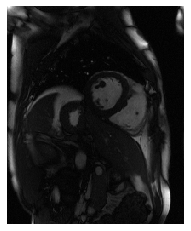

In [15]:
# Show the reconstructed cine image
from IPython.display import clear_output
import time

slc_idx = math.floor(SLC/2);
print(slc_idx)
image_slc = np.squeeze(image[:,:,:,:,:,:,slc_idx]);
for rep in range(5): # repeate the movie for 5 times
    for frame in range(image_slc.shape[2]):
      clear_output(wait=True)
      plt.imshow(image_slc[:,:,frame], cmap = 'gray'); plt.axis('off');
      plt.show() 
      time.sleep(0.03)